In [ ]:
# Bayesian optimization 说白了就是通过不断的采样迭代,找出一个函数的全局最小/最大值
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

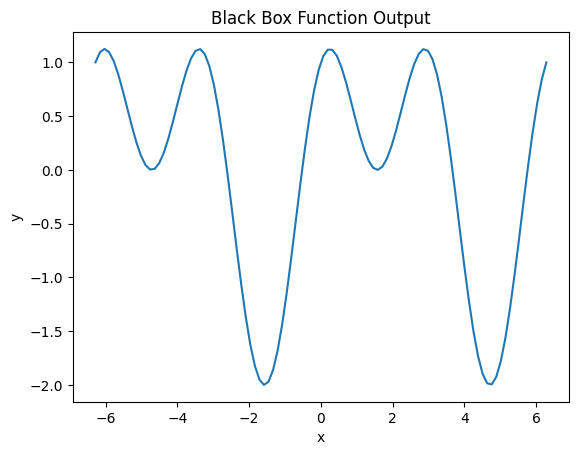

In [14]:
# 1. 构建一个黑箱模型
def black_box_function(x):
    y = np.sin(x) + np.cos(2*x)
    return y

# range of x values
x_range = np.linspace(-2*np.pi, 2*np.pi, 100)

# output for each x value
black_box_output = black_box_function(x_range)

# plot
plt.plot(x_range, black_box_output)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Black Box Function Output')
plt.show()

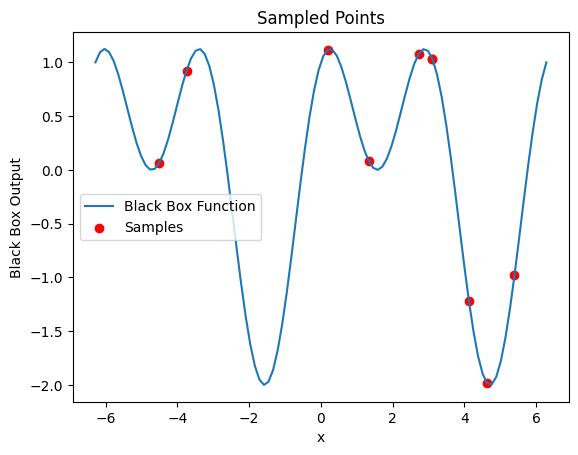

In [8]:
# 2. 在取直空间随机取值并放入黑箱模型中计算结果

# random x values for sampling
num_samples = 10
sample_x = np.random.choice(x_range, size=num_samples)

# output for each sampled x value
sample_y = black_box_function(sample_x)

# plot
plt.plot(x_range, black_box_function(x_range), label='Black Box Function')
plt.scatter(sample_x, sample_y, color='red', label='Samples')
plt.xlabel('x')
plt.ylabel('Black Box Output')
plt.title('Sampled Points')
plt.legend()
plt.show()

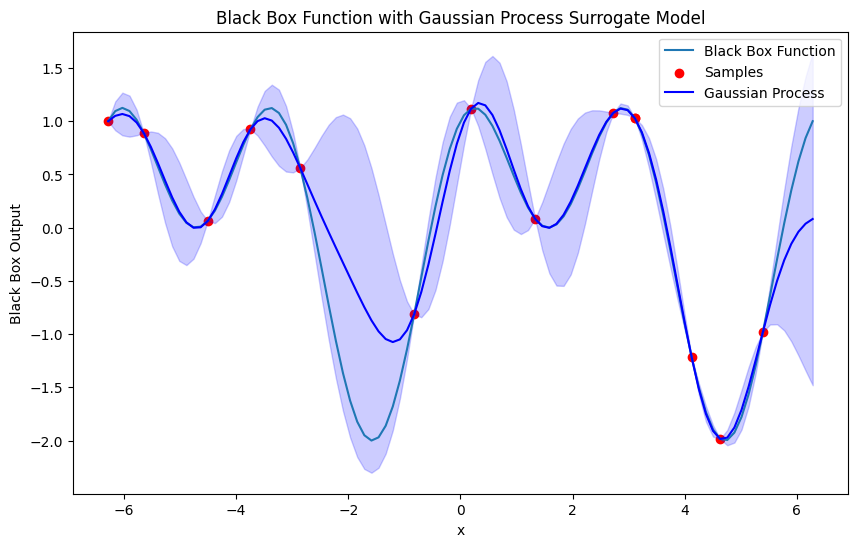

In [15]:
# 3. 使用一个代理函数去拟合随机取的值和模拟结果,是由一系列随机函数的集合组成

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


# Gaussian process regressor with an RBF kernel
kernel = RBF(length_scale=1.0)
gp_model = GaussianProcessRegressor(kernel=kernel)

# Fit the Gaussian process model to the sampled points
gp_model.fit(sample_x.reshape(-1, 1), sample_y)

# Generate predictions using the Gaussian process model
y_pred, y_std = gp_model.predict(x_range.reshape(-1, 1), return_std=True)

# Plot 
plt.figure(figsize=(10, 6))
plt.plot(x_range, black_box_function(x_range), label='Black Box Function')
plt.scatter(sample_x, sample_y, color='red', label='Samples')
plt.plot(x_range, y_pred, color='blue', label='Gaussian Process')
plt.fill_between(x_range, y_pred - 2*y_std, y_pred + 2*y_std, color='blue', alpha=0.2)
plt.xlabel('x')
plt.ylabel('Black Box Output')
plt.title('Black Box Function with Gaussian Process Surrogate Model')
plt.legend()
plt.show()

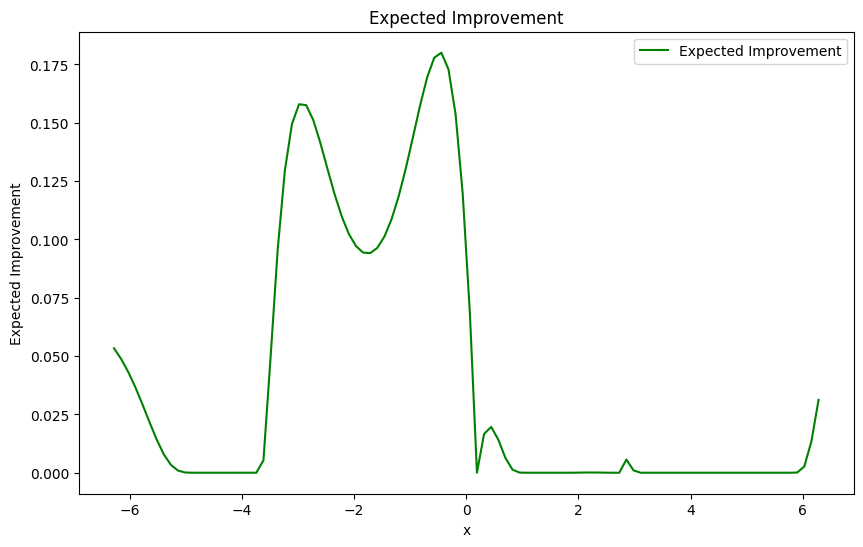

In [10]:
# 4. How do we choose the next point for the surrogate function? An Acquisition functions
# 说白了就是要基于采样点的数据和模拟结果,和拟合出来随机代理模型生成一个可能提升的期望分布  决定下一步该选择的点
# ================================================================================================
# Acquisition functions determine the next point or set of points to evaluate in the search space. 
# It quantifies the potential utility or desirability of sampling a particular point based on the current state of the optimization process. 
# The purpose of the acquisition function is to balance exploration and exploitation.
#
# Acquisition functions 同时考虑替代模型的预测值及其不确定性,从而选择具有较高可能值的点和不确定性大的点
# There are several acquisition functions used in Bayesian optimization:
# ================================================================================================


# ================================================================================================
# Expected Improvement (EI) 就是在模拟值最大的取值范围内进行采样
# EI selects points that have the potential to improve upon the best-observed value. 
# It quantifies the expected improvement over the current best value and 
# considers both the mean prediction of the surrogate model and its uncertainty.
# 选择有可能改进最佳观察值的点. 它量化当前最佳值的预期改进,并考虑替代模型的平均预测及其不确定性.
# ================================================================================================

from scipy.stats import norm

def expected_improvement(x, gp_model, best_y):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True) # 计算代理模型在整个区间内的模拟结果的均值和标准差
    z = (y_pred - best_y) / y_std # 计算出模型最优值所在的分位处
    ei = (y_pred - best_y) * norm.cdf(z) + y_std * norm.pdf(z) # 然后计算潜在的提升 (目前不是很理解原理)
    return ei

# Determine the point with the highest observed function value
best_idx = np.argmax(sample_y) 
best_x = sample_x[best_idx]
best_y = sample_y[best_idx]

ei = expected_improvement(x_range, gp_model, best_y)

# Plot the expected improvement
plt.figure(figsize=(10, 6))
plt.plot(x_range, ei, color='green', label='Expected Improvement')
plt.xlabel('x')
plt.ylabel('Expected Improvement')
plt.title('Expected Improvement')
plt.legend()
plt.show()

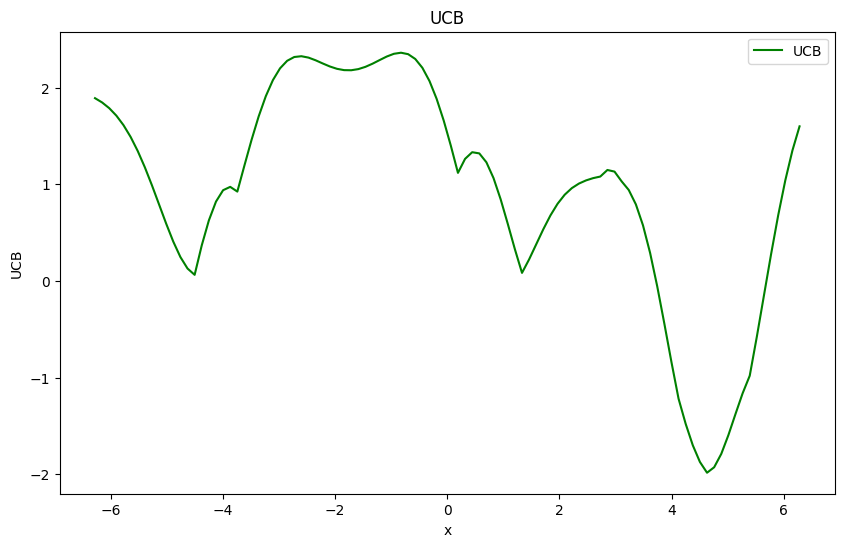

In [11]:
# Upper Confidence Bound (UCB) trades off exploration and exploitation by balancing the mean prediction of the surrogate model 
# and an exploration term proportional to the uncertainty. It selects points that offer a good balance between predicted high values and exploration of uncertain regions.

# 置信上限 (UCB) 通过平衡替代模型的平均预测和与不确定性成比例的探索项来权衡探索和获取. 它选择在预测高值和探索不确定区域之间提供良好平衡的点.

def upper_confidence_bound(x, gp_model, beta):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    ucb = y_pred + beta * y_std
    return ucb

beta = 2.0

# UCB
ucb = upper_confidence_bound(x_range, gp_model, beta)

plt.figure(figsize=(10, 6))
plt.plot(x_range, ucb, color='green', label='UCB')
plt.xlabel('x')
plt.ylabel('UCB')
plt.title('UCB')
plt.legend()
plt.show()

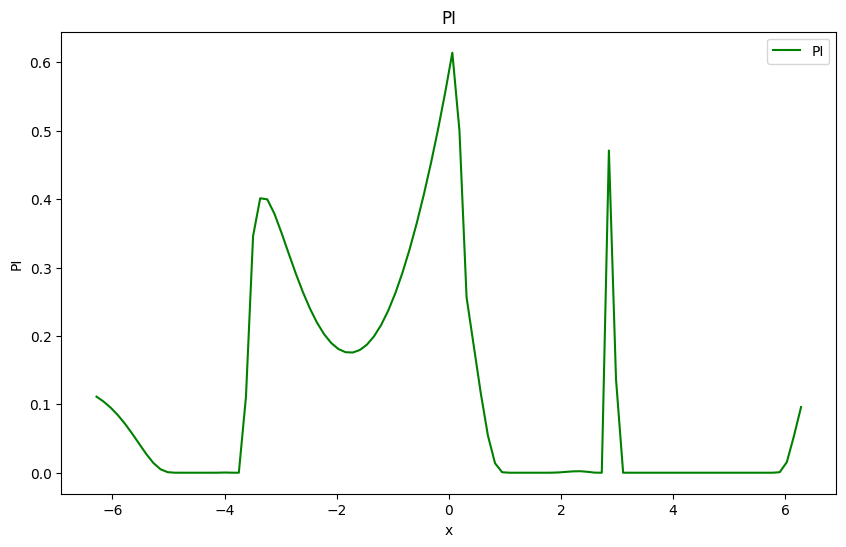

In [12]:
def probability_of_improvement(x, gp_model, best_y):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    z = (y_pred - best_y) / y_std
    pi = norm.cdf(z)
    return pi

# Probability of Improvement
pi = probability_of_improvement(x_range, gp_model, best_y)


plt.figure(figsize=(10, 6))
plt.plot(x_range, pi, color='green', label='PI')
plt.xlabel('x')
plt.ylabel('PI')
plt.title('PI')
plt.legend()
plt.show()

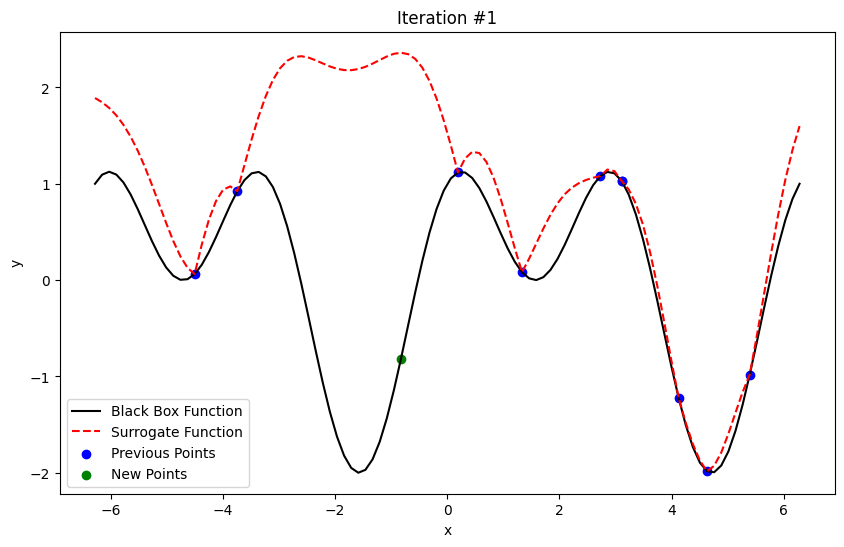

/opt/homebrew/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


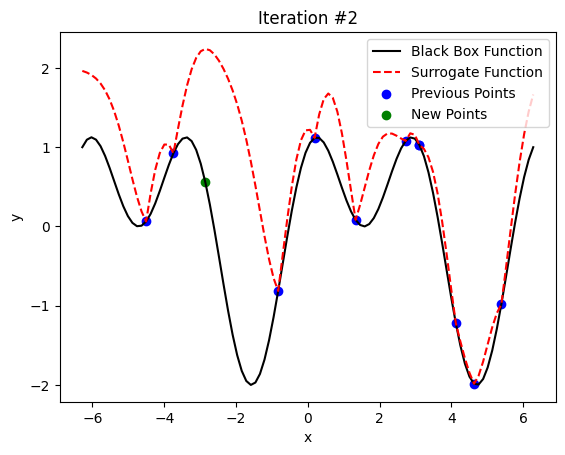

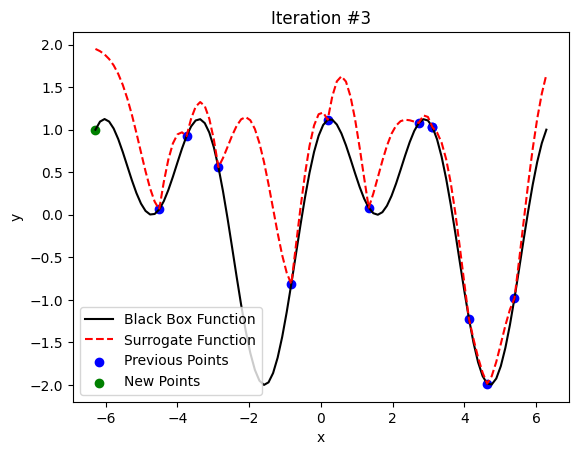

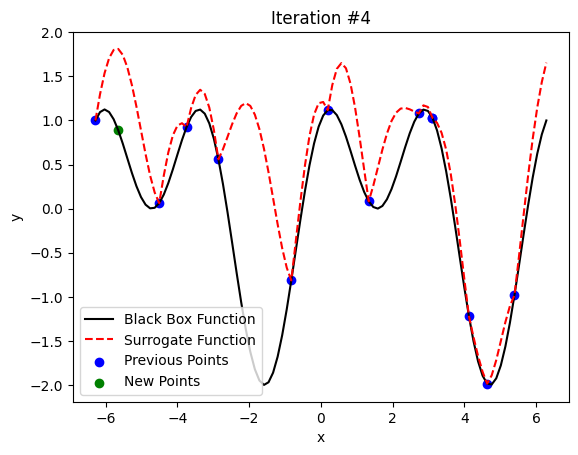

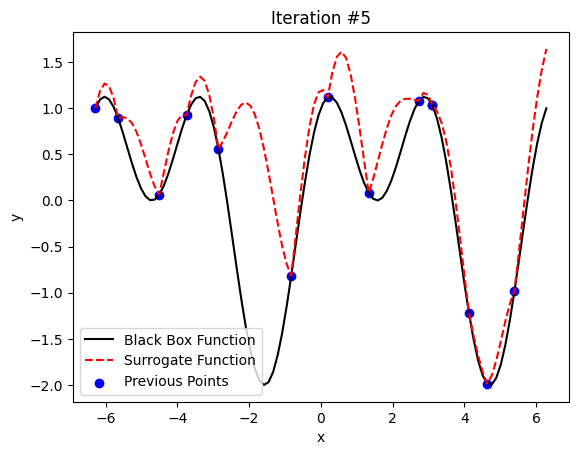

In [13]:
num_iterations = 5

plt.figure(figsize=(10, 6))

for i in range(num_iterations):
    # Fit the Gaussian process model to the sampled points
    gp_model.fit(sample_x.reshape(-1, 1), sample_y)

    # Determine the point with the highest observed function value
    best_idx = np.argmax(sample_y)
    best_x = sample_x[best_idx]
    best_y = sample_y[best_idx]

    # Set the value of beta for the UCB acquisition function
    beta = 2.0

    # Generate the Upper Confidence Bound (UCB) using the Gaussian process model
    ucb = upper_confidence_bound(x_range, gp_model, beta)

    # Plot the black box function, surrogate function, previous points, and new points
    plt.plot(x_range, black_box_function(x_range), color='black', label='Black Box Function')
    plt.plot(x_range, ucb, color='red', linestyle='dashed', label='Surrogate Function')
    plt.scatter(sample_x, sample_y, color='blue', label='Previous Points')
    if i < num_iterations - 1:
        new_x = x_range[np.argmax(ucb)]  # Select the next point based on UCB
        new_y = black_box_function(new_x)
        sample_x = np.append(sample_x, new_x)
        sample_y = np.append(sample_y, new_y)
        plt.scatter(new_x, new_y, color='green', label='New Points')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"Iteration #{i+1}")
    plt.legend()
    plt.show()